##### Слямзино с  Copyright 2019 The TensorFlow Authors. 

# Neural machine translation with attention

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/nmt_with_attention.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Будем создавать свой автопереводчик. На основе документации tf попробуем осознать, как работает внимание.
Пример ниже про испанский, попробуем получить тоже самое для русского

<img src="https://tensorflow.org/images/spanish-english.png" alt="spanish-english attention plot">

Note: This example takes approximately 10 minutes to run on a single P100 GPU. (больше :)))

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

## Download and prepare the dataset

Возьмем готовый дата сет http://www.manythings.org/anki/. Данные устроены следующим образом:

```
May I borrow this book?	Могу ли я одолжить книгу
```
Плюс какая-то дичь... (для русского языка в частности)

Что нам надо еще сделать с текстом
1. добавить *start* и *end* токен в каждое предложении.
2. Почистим все от ненужного (разные непонятные знаки).
3. Создать пару словарей (dictionaries mapping from word → id and id → word).
4. Ну и уровнять предложение по длине.

In [2]:
# Путь до файла

path_to_file = "rus.txt"

In [3]:
!nvidia-smi

Sat Oct  2 13:02:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    78W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
def preprocess_sentence(w):

    w.lower().strip()

    # Чистим выборку от разных знаков препинания
    # Убираем двойной пробел
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # еще чистим
    w = re.sub(r"[^a-zA-Z?.!,^а-яА-Я]+", " ", w)

    w = w.strip()

    # добавляем токены начали окончания предложения
    w = '<start> ' + w + ' <end>'
    return w

In [5]:
en_sentence = u"May I borrow this book?"
rus_sentence = u"Могу ли я одолжить эту книгу?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(rus_sentence))

<start> May I borrow this book ? <end>
<start> Могу ли я одолжить эту книгу ? <end>


In [6]:
# 1. Считали
# 2. почистили предложения
# 3. Вернули в след формате: [ENGLISH, RUSSIAN, Какая-то фигня]
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in line.split('\t')]
                for line in lines[:num_examples]]

    return list(zip(*word_pairs))

In [7]:
%%time
en,rus,non_know = create_dataset(path_to_file, None)
print(en[10])
print(rus[10])

<start> Run . <end>
<start> Беги ! <end>
CPU times: user 19.2 s, sys: 513 ms, total: 19.7 s
Wall time: 19.7 s


In [8]:
print(en[10100])
print(rus[10100])

<start> I felt strong . <end>
<start> Я почувствовал себя сильным . <end>


In [9]:
print(en[-1])
print(rus[-1])

<start> Doubtless there exists in this world precisely the right woman for any given man to marry and vice versa but when you consider that a human being has the opportunity of being acquainted with only a few hundred people , and out of the few hundred that there are but a dozen or less whom he knows intimately , and out of the dozen , one or two friends at most , it will easily be seen , when we remember the number of millions who inhabit this world , that probably , since the earth was created , the right man has never yet met the right woman . <end>
<start> Несомненно , для каждого мужчины в этом мире где то есть подходящая женщина , которая может стать ему женой , обратное верно и для женщин . Но если учесть , что у человека может быть максимум несколько сотен знакомых , из которых лишь дюжина , а то и меньше , тех , кого он знает близко , а из этой дюжины у него один или от силы два друга , то можно легко увидеть , что с учетом миллионов живущих на Земле людей , ни один подходящи

In [10]:
len(rus)

421765

In [11]:
def tokenize(lang):
    # токенизируем
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    # добавляем padding 
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

    return tensor, lang_tokenizer

In [12]:
def load_dataset(path, num_examples=None):
    # считали, вернули пары
    targ_lang, inp_lang,non_known = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### Limit the size of the dataset to experiment faster (optional)

Обучение на всех данных длительный процесс. Можем взять кусок данных и надеяться что все заработает)

In [13]:
# Выбор количества примеров это важная часть
num_examples = 50000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file,
                                                                num_examples)

# считаем максимальные длины всех предложений
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [14]:
# Трейн тест сплит
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)


print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

40000 40000 10000 10000


In [15]:
# преврощение в словари
def convert(lang, tensor):
    for t in tensor:
        if t != 0:
            print(f'{t} ----> {lang.index_word[t]}')

In [16]:
input_tensor_val

array([[   1,  228,   25, ...,    0,    0,    0],
       [   1,  762,   18, ...,    0,    0,    0],
       [   1,   12,  207, ...,    0,    0,    0],
       ...,
       [   1,    4, 1116, ...,    0,    0,    0],
       [   1, 5433,   19, ...,    0,    0,    0],
       [   1,    4, 9172, ...,    0,    0,    0]], dtype=int32)

In [17]:
print("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print()
print("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
9 ----> ты
236 ----> хочешь
474 ----> детей
5 ----> ?
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
22 ----> do
6 ----> you
65 ----> want
336 ----> kids
7 ----> ?
2 ----> <end>


### Create a tf.data dataset

In [18]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 512
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [19]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([512, 15]), TensorShape([512, 9]))

## Write the encoder and decoder model

Пример реалзиации энкодера и декодера для машинного перевода можно чекнуть тут [Neural Machine Translation (seq2seq) tutorial](https://github.com/tensorflow/nmt). Мы же посмотрим на attention [attention equations](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism). На картинке смотрим, что там происходит с вниманием. Объяснение взято из статьи [Luong's paper](https://arxiv.org/abs/1508.04025v5). 

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

Мы возвращаем все последовательность скрытых состояний из encoder *(batch_size, max_length, hidden_size)* и последнее скрытые состояния *(batch_size, hidden_size)*.

Можем посмотреть на уравнения, которые у нас есть:

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

Мы возьме вот такой attention [Bahdanau attention](https://arxiv.org/pdf/1409.0473.pdf) для энкодера. и  можем взять описание того, что есть:

* FC = Fully connected (dense) layer
* EO = Encoder output
* H = hidden state
* X = input to the decoder

И наш псевдо-код:

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`. Softmax по умолчанию применяется к последней оси нашего тензора, но здесь мы хотим применить его к * 1-й оси *, так как наши данные имеют следующий вид * (batch_size, max_length, hidden_size) *. Max_length - длина нашей последовательности. И мы хотим дать вес каждому элементу последовательности, поэтому и применяем softmax именно так.

* `context vector = sum(attention weights * EO, axis = 1)`. 
* `embedding output` = Эмбедим наш выход.
* `merged vector = concat(embedding output, context vector)`
* И этот вектор мы и отдаем дальше

Смотрим на реализацию!

In [20]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [21]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# пример всего того, что у нас получилося
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print('Encoder output shape: (batch size, sequence length, units)', sample_output.shape)
print('Encoder Hidden state shape: (batch size, units)', sample_hidden.shape)

Encoder output shape: (batch size, sequence length, units) (512, 15, 1024)
Encoder Hidden state shape: (batch size, units) (512, 1024)


In [22]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [23]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units)", attention_result.shape)
print("Attention weights shape: (batch_size, sequence_length, 1)", attention_weights.shape)

Attention result shape: (batch size, units) (512, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (512, 15, 1)


In [24]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [25]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print('Decoder output shape: (batch_size, vocab size)', sample_decoder_output.shape)

Decoder output shape: (batch_size, vocab size) (512, 4774)


## Define the optimizer and the loss function

In [26]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction='none')


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [27]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training


1. Энкодим наш вход
2. Выход энкодера засовываем в декодер
3. Прогноз декодера используем для расчета лосса и возвращаем скрытое состояния для следующего прогноза
4. Используем *teacher forcing* решаем какой инпут дать декодеру дальше.
5. *Teacher forcing* это техника когда *target word* используем как *next input* декодер.
6. Итоговый результат используем как результат и считаем лосс

In [28]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        # Teacher forcing - скармливаем
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [29]:
EPOCHS = 1000

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy():.4f}')
        # сохранялка
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

    print(f'Epoch {epoch+1} Loss {total_loss/steps_per_epoch:.4f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 5.3110
Epoch 1 Loss 2.8268
Time taken for 1 epoch 60.07 sec

Epoch 2 Batch 0 Loss 2.2561
Epoch 2 Loss 2.0119
Time taken for 1 epoch 46.27 sec

Epoch 3 Batch 0 Loss 1.7420
Epoch 3 Loss 1.6699
Time taken for 1 epoch 45.43 sec

Epoch 4 Batch 0 Loss 1.4953
Epoch 4 Loss 1.4591
Time taken for 1 epoch 46.02 sec

Epoch 5 Batch 0 Loss 1.3339
Epoch 5 Loss 1.2955
Time taken for 1 epoch 45.52 sec

Epoch 6 Batch 0 Loss 1.1947
Epoch 6 Loss 1.1465
Time taken for 1 epoch 46.11 sec

Epoch 7 Batch 0 Loss 1.0205
Epoch 7 Loss 1.0082
Time taken for 1 epoch 45.51 sec

Epoch 8 Batch 0 Loss 0.8723
Epoch 8 Loss 0.8828
Time taken for 1 epoch 46.15 sec

Epoch 9 Batch 0 Loss 0.7857
Epoch 9 Loss 0.7666
Time taken for 1 epoch 45.55 sec

Epoch 10 Batch 0 Loss 0.6642
Epoch 10 Loss 0.6572
Time taken for 1 epoch 46.21 sec

Epoch 11 Batch 0 Loss 0.5498
Epoch 11 Loss 0.5573
Time taken for 1 epoch 45.44 sec

Epoch 12 Batch 0 Loss 0.4792
Epoch 12 Loss 0.4673
Time taken for 1 epoch 46.09 sec

Epoch 13 B

KeyboardInterrupt: ignored

## Translate

* Все похоже на обучение, только мы не можем подсовывать нормальное слово в декодер.
* Как только модель предсказала конец предложения останавливаем обучения
* Храним выводы attention на каждом шаге


In [30]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [31]:
# рисовалка внимания
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [32]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input:', sentence)
    print('Predicted translation:', result)

    attention_plot = attention_plot[:len(result.split(' ')),
                                  :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## Restore the latest checkpoint and test

In [33]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> я очень старый человек . <end>
Predicted translation: i a very very old thin shy . shy 


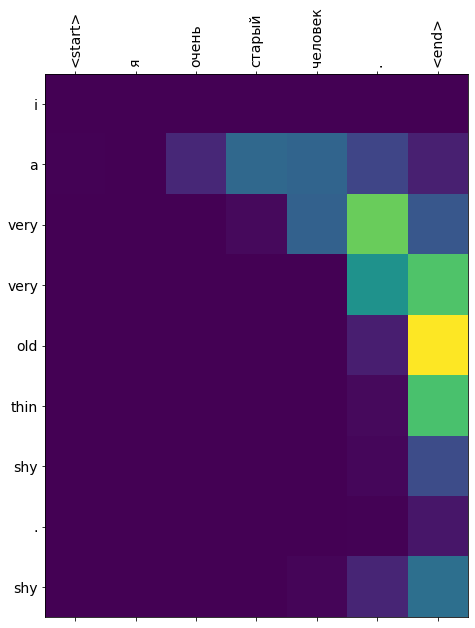

In [34]:
translate(u'я очень старый человек .')

Input: <start> мы поможем тебе . <end>
Predicted translation: we you you you you you help help help 


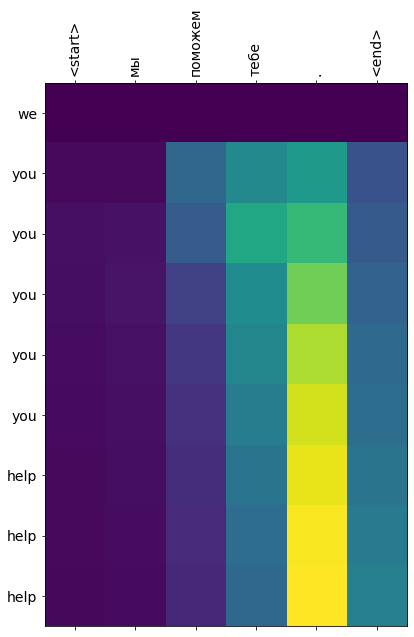

In [51]:
translate(u'мы поможем тебе.')

Input: <start> мы помочь тебе . <end>
Predicted translation: we help help help help you you you you 


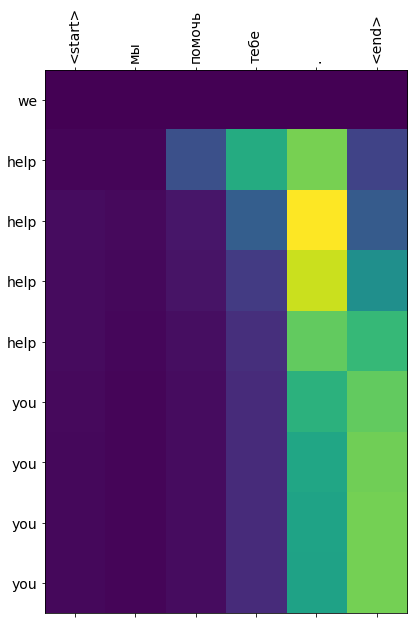

In [49]:
translate(u'мы помочь тебе.')

## Next steps

* Эксперементы :)
